In [1]:
import os
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

In [2]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=.6)

In [3]:
llm.invoke([HumanMessage(content="Hello, how are you?")])

AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 13, 'total_tokens': 42, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-BZmetdjwePDrjF8aGRt0AkJnCXtMu', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e1dcc17f-0d50-45e5-a4e1-81d051e4c136-0', usage_metadata={'input_tokens': 13, 'output_tokens': 29, 'total_tokens': 42, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [4]:
sys_msg = [
    SystemMessage(content="You are a personal coach tasked with helping the user handle their conflicts."\
                  " You will help the user by asking clarifying questions, providing feedback, and offering"\
                  " suggestions on how to approach the situation. Your goal is to provide the user with a response"\
                  " that comes from a place of empathy."),
]

def gather_context(state: MessagesState):
    # TODO: gather the context, ask user if needed
    return {}

def summarize_context(state: MessagesState):
    # TODO: summarize the context
    return {}

def response(state: MessagesState):
    print(state)
    return {"messages": [llm.invoke(sys_msg + state["messages"])]}


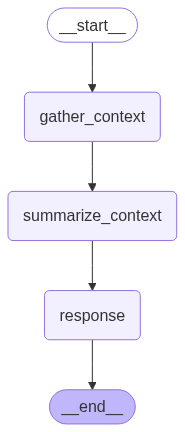

In [14]:
builder = StateGraph(MessagesState)

# Add nodes to the graph
builder.add_node("gather_context", gather_context)
builder.add_node("summarize_context", summarize_context)
builder.add_node("response", response)

# Add edges to the graph
builder.add_edge(START, "gather_context")
builder.add_edge("gather_context", "summarize_context")
builder.add_edge("summarize_context", "response")
builder.add_edge("response", END)
react_graph = builder.compile()

# react_graph.get_graph(xray=True).print_ascii()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="You didn't put the laundry away, you never do anything!")]
react_graph.invoke({"messages": messages})

{'messages': [HumanMessage(content="You didn't put the laundry away, you never do anything!", additional_kwargs={}, response_metadata={}, id='32381ae8-441b-4baa-8b83-54fbfb311e22')]}


{'messages': [HumanMessage(content="You didn't put the laundry away, you never do anything!", additional_kwargs={}, response_metadata={}, id='32381ae8-441b-4baa-8b83-54fbfb311e22'),
  AIMessage(content="It sounds like you're feeling really frustrated about the laundry situation. Can you tell me more about what's been going on? How often do you find yourself feeling this way, and what do you think might be behind those feelings? Understanding the context could help us figure out a good way to address it.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 79, 'total_tokens': 138, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54eb4bd693', 'id': 'chatcmpl-BZmVJGdkWImo5CZSr5V1lmnUS92NT', 'service_tier': '